In [1]:
import os
import random
import torch
import torchvision.transforms as standard_transforms
import scipy.io as sio
import matplotlib
import pandas as pd
import misc.transforms as own_transforms

from torch.autograd import Variable
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm import trange
from misc.utils import *
from models.CC import CrowdCounter
from config import cfg

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

mean_std = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])

img_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
restore = standard_transforms.Compose([
        own_transforms.DeNormalize(*mean_std),
        standard_transforms.ToPILImage()
    ])
pil_to_tensor = standard_transforms.ToTensor()

dataRoot = '/datasets/shanghaitech_part_B/test/'
model_path = '/home/crowd/shb-mcnn/weights/mcnn_all_ep_285_mae_23.3_mse_36.1.pth'

/home/crowd/miniconda3/envs/c3/lib/python3.8/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


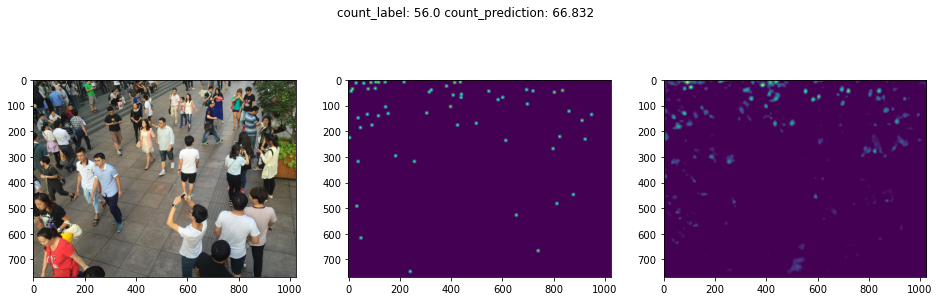

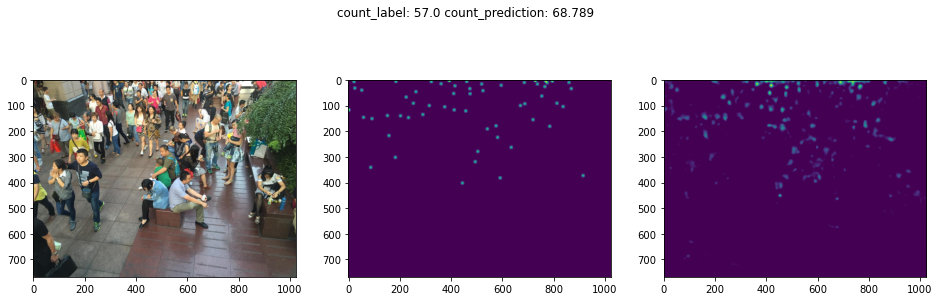

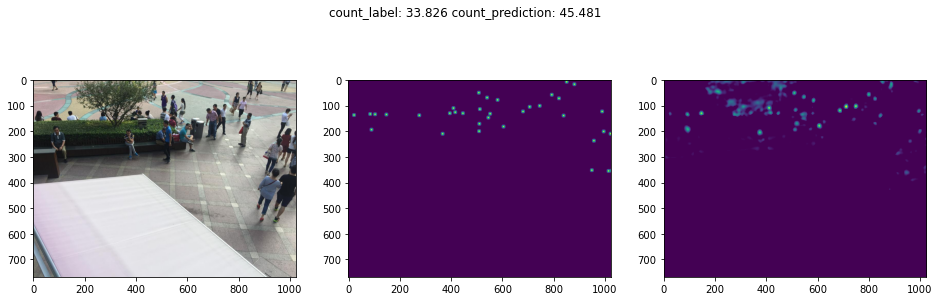

In [2]:
net = CrowdCounter(cfg.GPU_ID,cfg.NET)
net.load_state_dict(torch.load(model_path))
net.cuda()
net.eval()

file_list = [filename for root,dirs,filename in os.walk(os.path.join(dataRoot, 'img'))][0]

for filename in random.sample(file_list, 3):
    imgname = os.path.join(dataRoot, 'img', filename)
    filename_no_ext = filename.split('.')[0]

    img_orygin = Image.open(imgname)
    if img_orygin.mode == 'L':
        img_orygin = img_orygin.convert('RGB')

    denname = os.path.join(dataRoot, 'den', filename_no_ext + '.csv')
    den = pd.read_csv(denname, sep=',',header=None).values
    den = den.astype(np.float32, copy=False)
    gt = np.sum(den)

    img = img_transform(img_orygin)
    with torch.no_grad():
        img = Variable(img[None,:,:,:]).cuda()
        pred_map = net.test_forward(img)
    pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
    pred = np.sum(pred_map)/100.0

    pred_map = pred_map/np.max(pred_map+1e-20)
    den = den/np.max(den+1e-20)


    fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle(' '.join([
            'count_label:', str(round(gt, 3)),
            'count_prediction:', str(round(pred, 3))
        ]))
    ax0.imshow(img_orygin)
    ax1.imshow(den)
    ax2.imshow(pred_map)
    plt.show()

In [3]:
file_list = [filename for root,dirs,filename in os.walk(os.path.join(dataRoot, 'img'))][0]

mae = np.empty(len(file_list))
mse = np.empty(len(file_list))

for i in trange(len(file_list)):  
    filename = file_list[i]
    imgname = os.path.join(dataRoot, 'img', filename)
    filename_no_ext = filename.split('.')[0]

    img_orygin = Image.open(imgname)
    if img_orygin.mode == 'L':
        img_orygin = img_orygin.convert('RGB')

    denname = os.path.join(dataRoot, 'den', filename_no_ext + '.csv')
    den = pd.read_csv(denname, sep=',',header=None).values
    den = den.astype(np.float32, copy=False)
    gt = np.sum(den)

    img = img_transform(img_orygin)
    with torch.no_grad():
        img = Variable(img[None,:,:,:]).cuda()
        pred_map = net.test_forward(img)
    pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
    pred = np.sum(pred_map)/100.0

    pred_map = pred_map/np.max(pred_map+1e-20)
    den = den/np.max(den+1e-20)
    
    mae[i] = np.abs(gt-pred)
    mse[i] = (gt-pred)**2
    
print('MAE:', mae.mean())
print('MSE:', np.sqrt(mse.mean()))

100%|██████████| 316/316 [00:33<00:00,  9.50it/s]

MAE: 23.264252635376366
MSE: 36.06584100455671
